In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")

import re
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from nltk import sent_tokenize, word_tokenize
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, make_scorer

from time import time
import pickle

In [2]:
df = pd.read_csv("dataset.csv")

In [3]:
df.head()

,headline,label
0,cock suck before you piss around on my work,-1
1,you are gay or antisemmitian archangel white ...,-1
2,fuck your filthy mother in the ass dry,-1
3,get fuck ed up get fuck ed up got a drink t...,-1
4,stupid peace of shit stop deleting my stuff ...,-1


In [4]:
df['label'].unique()

array([-1,  0], dtype=int64)

Dataframe manipulation

In [ ]:
def perform_data_manipulation():
    df = pd.read_csv("dataset.csv")
    
    for index in df.index:
        if df.loc[index, "label"]==-1:
            df.loc[index, "label"] = 1
    return df

In [6]:
df = perform_data_manipulation()

In [7]:
df.head()

,headline,label
0,cock suck before you piss around on my work,1
1,you are gay or antisemmitian archangel white ...,1
2,fuck your filthy mother in the ass dry,1
3,get fuck ed up get fuck ed up got a drink t...,1
4,stupid peace of shit stop deleting my stuff ...,1


In [63]:
df['label'].unique()

array([1, 0], dtype=int64)

In [64]:
df.shape[0]

18148

Classification using Pie Chart

In [8]:
def performdatadistribution(df, save_path='static/toxic_distribution.png'):
    total = df.shape[0]
    num_non_toxic = df[df['label']==0].shape[0]
    
    slices = [num_non_toxic/total, (total-num_non_toxic)/total]
    
    labeling = ['Non-Toxic', 'Toxic']
    
    explode = [0.2, 0]
    
    plt.pie(slices, explode = explode, shadow=True, autopct="%1.1f%%", labels = labeling, wedgeprops={'edgecolor': 'black'})
    
    plt.title('Number of Toxic Vs Non- Toxic Test Sample')
    
    plt.savefig(save_path)
    plt.close()  

In [9]:
performdatadistribution(df)

In [10]:
def remove_pattern(input_txt, pattern):
    if (type(input_txt)==str):
        r = re.findall(pattern, input_txt)
        for i in r:
            input_txt = re.sub(i, '', input_txt)
        return input_txt
    else:
        return ""

In [11]:
df.head(1)

,headline,label
0,cock suck before you piss around on my work,1


In [12]:
def datasetCleaning(df):
    df['length_headline'] = df['headline'].str.len()
    combined_df = df.append(df, ignore_index=True)
#     remove @ user
    combined_df['tidy_tweet'] = np.vectorize(remove_pattern)(combined_df['headline'], "@[\w]*")
    
#     remove extra letters
    combined_df['tidy_tweet'] = combined_df['tidy_tweet'].str.replace("[^a-zA-Z#]", " ")
    
#     remove all those words with size less than 3
    combined_df['tidy_tweet'] = combined_df['tidy_tweet'].apply(lambda x : ' '.join([w for w in x.split() if len(w)>3]))
    
    combined_df['length_tidy_tweet'] = combined_df['tidy_tweet'].str.len()
    
#     Tokenized
    tokenized_tweet = combined_df['tidy_tweet'].apply(lambda x : x.split())
    
    nltk.download('wordnet')
    
    lemmatizer = nltk.stem.WordNetLemmatizer()
    
    tokenized_tweet = tokenized_tweet.apply(lambda x :[lemmatizer.lemmatize(i) for i in x])
    
    for i in range(len(tokenized_tweet)):
        tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
    combined_df['tidy_tweet'] = tokenized_tweet
    
    return combined_df, df
    

In [13]:
combined_df, df =datasetCleaning(df)

C:\Users\Vijay\AppData\Local\Temp\ipykernel_1520\2227267524.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_df = df.append(df, ignore_index=True)
C:\Users\Vijay\AppData\Local\Temp\ipykernel_1520\2227267524.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  combined_df['tidy_tweet'] = combined_df['tidy_tweet'].str.replace("[^a-zA-Z#]", " ")
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Vijay\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [14]:
combined_df.head()

,headline,label,length_headline,tidy_tweet,length_tidy_tweet
0,cock suck before you piss around on my work,1,44,cock suck before piss around work,33
1,you are gay or antisemmitian archangel white ...,1,624,antisemmitian archangel white tiger meow greet...,400
2,fuck your filthy mother in the ass dry,1,39,fuck your filthy mother,23
3,get fuck ed up get fuck ed up got a drink t...,1,121,fuck fuck drink that cant down fuck fuck fuck ...,51
4,stupid peace of shit stop deleting my stuff ...,1,93,stupid peace shit stop deleting stuff hole fal...,57


Dataset Splitting

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
def performdatasplit(x, y, combined_df, df):
    X_train, X_test, y_train, y_test = train_test_split(combined_df['tidy_tweet'], combined_df['label'], test_size = x, random_state = y)
    print(f"Number of rows in the total dataset: {combined_df.shape[0]}")
    print(f"Number of rows in the train dataset: {X_train.shape[0]}")
    print(f"Number of rows in the test dataset: {X_test.shape[0]}")
    
    files = open("stopwords.txt" , "r")
    content = files.read()
    content_list = content.split("\n")
    files.close()
    
    tfidfvector = TfidfVectorizer(stop_words=content_list, lowercase=True)
    
    training_data = tfidfvector.fit_transform(X_train.values.astype('U'))
    
    testing_data = tfidfvector.transform(X_test.values.astype('U'))
    
    filename = 'tfidfvectoizer.pkl'
    
    pickle.dump(tfidfvector.vocabulary_, open(filename, 'wb'))
    
    return X_train , X_test, y_train, y_test, testing_data, filename, training_data, content_list

In [17]:
X_train , X_test, y_train, y_test, testing_data, filename, training_data, content_list = performdatasplit(0.2, 42, combined_df, df)

Number of rows in the total dataset: 36296
Number of rows in the train dataset: 29036
Number of rows in the test dataset: 7260


C:\Users\Vijay\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ninad'] not in stop_words.
  warnings.warn(


Apply Machine Learning Algorithm

In [18]:
import xgboost as xgb
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier

In [19]:
def pipeline(X_train, y_train, X_test, y_test):
    MODELS = [LinearSVC(), LogisticRegression(), MultinomialNB(), DecisionTreeClassifier(),
              AdaBoostClassifier(), BaggingClassifier(), SGDClassifier()]
    
    size = len(y_train)
    
    results = {}
    
    final_result = []
    
    for model in MODELS:
        results['Algorithm'] = model.__class__.__name__
        
        start = time()
        print(f"Training Time : {model.__class__.__name__}")
        model.fit(X_train, y_train)
        end = time()
        
        filename = model.__class__.__name__+".pkl"
        pickle.dump(model, open(filename, "wb"))
        
        results['Training Time'] = end - start
        
        start = time()
        prediction_test = model.predict(X_test)
        prediction_train = model.predict(X_train)
        end = time()
        
        results['Prediction Time'] = end - start
        
        results['Accuracy : Test'] = accuracy_score(y_test, prediction_test)
        results['Accuracy : Train'] = accuracy_score(y_train, prediction_train)
        
        results['F1 Score : Test'] = f1_score(y_test, prediction_test)
        results['F1 Score : Train'] = f1_score(y_train, prediction_train)
        
        results['Precision : Test'] = precision_score(y_test, prediction_test)
        results['Precision : Train'] = precision_score(y_train, prediction_train)
        
        results['Recall : Test'] = recall_score(y_test, prediction_test)
        results['Recall : Train'] = recall_score(y_train, prediction_train)
        
        print(f"Training {model.__class__.__name__} finished in {results['Training Time']} sec")
        
        final_result.append(results.copy())
    return final_result
        

In [20]:
final_result = pipeline(training_data, y_train, testing_data, y_test)

Training Time : LinearSVC
Training LinearSVC finished in 0.8730111122131348 sec
Training Time : LogisticRegression
Training LogisticRegression finished in 2.7856545448303223 sec
Training Time : MultinomialNB
Training MultinomialNB finished in 0.15623879432678223 sec
Training Time : DecisionTreeClassifier
Training DecisionTreeClassifier finished in 20.91459035873413 sec
Training Time : AdaBoostClassifier
Training AdaBoostClassifier finished in 17.048675298690796 sec
Training Time : BaggingClassifier
Training BaggingClassifier finished in 269.12069368362427 sec
Training Time : SGDClassifier
Training SGDClassifier finished in 1.6486940383911133 sec


In [22]:
def performfinalresult(final_results):
    results = pd.DataFrame(final_results)
    results.reindex(columns = ['Algorithm', 'Accuracy : Test', 'Precision : Test', 'Recall : Test', 'F1 Score : Test', 'Prediction Time',
                          'Accuracy : Train', 'Precision : Train', 'Recall : Train', 'F1 Score : Train', 'Training Time'])
    results.sort_values(by = 'F1 Score : Test', inplace=True, ascending=False)
    
    return results

In [23]:
results = performfinalresult(final_result)
results.reset_index(drop = True)
results.to_html("static/results_table.html", index=False, classes="table table-bordered table-striped")
print("Table saved successfully in static folder!")

Table saved successfully in static folder!


In [24]:
results.describe().loc[['min', 'max'], :]

,Training Time,Prediction Time,Accuracy : Test,Accuracy : Train,F1 Score : Test,F1 Score : Train,Precision : Test,Precision : Train,Recall : Test,Recall : Train
min,0.156239,0.006000,0.838567,0.839027,0.861466,0.860519,0.885313,0.915035,0.776476,0.773955
max,269.120694,0.752621,0.973967,0.996384,0.980011,0.997186,0.972911,0.995665,0.987215,0.998712


Summary IN Graph

Graph saved successfully in static folder!


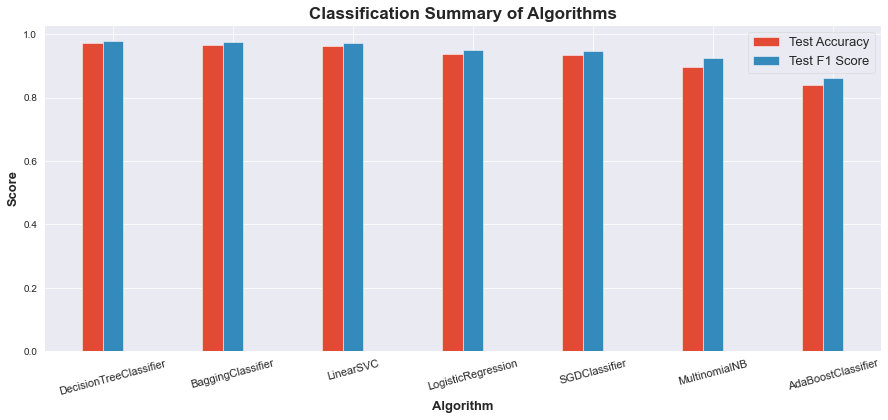

In [25]:
best_acc = results[results['Accuracy : Test'] == results['Accuracy : Test'].max()]
best_f1 = results[results['F1 Score : Test'] == results['F1 Score : Test'].max()]
best_precision = results[results['Precision : Test'] == results['Precision : Test'].max()]
best_recall = results[results['Recall : Test'] == results['Recall : Test'].max()]

sns.set_style('darkgrid')
plt.figure(figsize = (15, 6))

barWidth = 0.17
 
# set height of bar
bars1 = results['Accuracy : Test']
bars2 = results['F1 Score : Test']

# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

# Make the plot
pal = sns.color_palette()
plt.bar(r1, bars1, color= pal[0], width=barWidth, edgecolor='white', label='Test Accuracy')
plt.bar(r2, bars2, color= pal[1], width=barWidth, edgecolor='white', label='Test F1 Score')

# Add xticks on the middle of the group bars
plt.xlabel('Algorithm', fontweight='bold', fontsize = 13)
plt.ylabel('Score', fontweight = 'bold', fontsize = 13)
plt.xticks([r + barWidth for r in range(len(bars1))], results['Algorithm'], rotation = 15, fontsize = 11)
 
# Create legend & Show graphic
plt.legend(fontsize = 13)

textstr = '\n'.join(['Best Accuracy: {:.3f} - {}'.format(best_acc['Accuracy : Test'].values[0], best_acc['Algorithm'].values[0]), 
                     'Best F1 Score: {:.3f} - {}'.format(best_f1['F1 Score : Test'].values[0], best_f1['Algorithm'].values[0])])
props = dict(boxstyle='round', facecolor='lightgrey', alpha=0.5)

plt.title('Classification Summary of Algorithms', fontweight = 'bold', fontsize = 17);
plt.savefig("static/classification_summary.png")
print("Graph saved successfully in static folder!")


Training and Prediction time of Algorithm

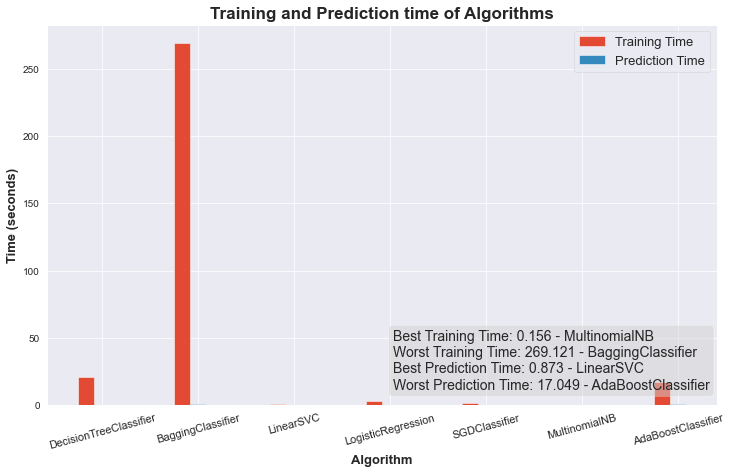

In [26]:

best_train_time = results[results['Training Time'] == results['Training Time'].min()]
worst_train_time = results[results['Training Time'] == results['Training Time'].max()]
best_prediction_time = results[results['Prediction Time'] == results['Prediction Time'].min()]
worst_prediction_time = results[results['Prediction Time'] == results['Prediction Time'].max()]

plt.figure(figsize = (12, 7))

barWidth = 0.17
 
# set height of bar
bars1 = results['Training Time']
bars2 = results['Prediction Time']
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.bar(r1, bars1, color= pal[0], width=barWidth, edgecolor='white', label='Training Time')
plt.bar(r2, bars2, color= pal[1], width=barWidth, edgecolor='white', label='Prediction Time')
 
# Add xticks on the middle of the group bars
plt.xlabel('Algorithm', fontweight='bold', fontsize = 13)
plt.ylabel('Time (seconds)', fontweight = 'bold', fontsize = 13)
plt.xticks([r + barWidth for r in range(len(bars1))], results['Algorithm'], rotation = 15, fontsize = 11)


textstr = '\n'.join(('Best Training Time: {:.3f} - {}'.format(best_train_time['Training Time'].values[0], best_train_time['Algorithm'].values[0]), 
                     'Worst Training Time: {:.3f} - {}'.format(worst_train_time['Training Time'].values[0], worst_train_time['Algorithm'].values[0]),
                   'Best Prediction Time: {:.3f} - {}'.format(best_prediction_time['Training Time'].values[0], best_prediction_time['Algorithm'].values[0]), 
                    'Worst Prediction Time: {:.3f} - {}'.format(worst_prediction_time['Training Time'].values[0], worst_prediction_time['Algorithm'].values[0])))
props = dict(boxstyle='round', facecolor='lightgrey', alpha=0.5)

#place a text box
plt.text(3.2, 12, textstr, fontsize=14,  bbox=props) 

# Create legend & Show graphic
plt.legend(fontsize = 13)
plt.title('Training and Prediction time of Algorithms', fontweight = 'bold', fontsize = 17)
plt.savefig("static/training_and_prediction.png")

In [27]:
df.head()

,headline,label,length_headline
0,cock suck before you piss around on my work,1,44
1,you are gay or antisemmitian archangel white ...,1,624
2,fuck your filthy mother in the ass dry,1,39
3,get fuck ed up get fuck ed up got a drink t...,1,121
4,stupid peace of shit stop deleting my stuff ...,1,93


In [28]:
data = ["You are so beautiful"]

tfidf_vector = TfidfVectorizer(stop_words=content_list, lowercase=True, vocabulary=pickle.load(open("tfidfvectoizer.pkl", "rb")))
preprocessed_data = tfidf_vector.fit_transform(data)

trained_model = pickle.load(open('LinearSVC.pkl', 'rb'))
print(trained_model.predict(preprocessed_data))

if(trained_model.predict(preprocessed_data)==1):
    print("bulling")
else:
    print("non-bulling")

C:\Users\Vijay\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ninad'] not in stop_words.
  warnings.warn(


[0]
non-bulling


Fine Tuining

In [31]:
from sklearn.model_selection import GridSearchCV

def tuining(clf, param_dict, X_train, y_train, X_test, y_test):
    scorer = make_scorer(f1_score)
    
    grid_obj = GridSearchCV(estimator=clf, param_grid=param_dict, scoring=scorer, cv=5)
    
    grid_fit = grid_obj.fit(X_train, y_train)
    
    best_clf = grid_fit.best_estimator_
    
    prediction = (clf.fit(X_train, y_train)).predict(X_test)
    
    best_prediction = best_clf.predict(X_test)
    
    print(clf.__class__.__name__)
    print(f"Best Parameter:  {grid_fit.best_params_}")
    
    print(f"Accuracy:  {accuracy_score(y_test, best_prediction)}")

    print(f"F1 Score :  {f1_score(y_test, best_prediction)}")
    
    print(f"Precision :  {precision_score(y_test, best_prediction)}")
    
    print(f"Recall:  {recall_score(y_test, best_prediction)}")
    
    results = {
        "Model": [clf.__class__.__name__],
        "Best Parameters": [grid_fit.best_params_],
        "Accuracy": [accuracy_score(y_test, best_prediction)],
        "F1 Score": [f1_score(y_test, best_prediction)],
        "Precision": [precision_score(y_test, best_prediction)],
        "Recall": [recall_score(y_test, best_prediction)]
    }
    
    df_results = pd.DataFrame(results)

    df_results.to_html("static/results.html", index=False, classes="table table-bordered table-striped")
    print("Table saved successfully in static folder!")

In [32]:
param_grid = {
    'C': [0.25, 0.5, 0.75, 1, 1.2]
}

clf_model = LinearSVC()

tuining(clf_model, param_grid, training_data, y_train, testing_data, y_test)

LinearSVC
Best Parameter:  {'C': 1.2}
Accuracy:  0.9644628099173553
F1 Score :  0.9724888035828534
Precision :  0.9733191035218783
Recall:  0.97165991902834
Table saved successfully in static folder!


In [33]:
pickle.dump(clf_model, open("LinearSVCTuned.pkl", "wb"))